# DATA IMPUTATION
UCI:        https://archive.ics.uci.edu/ml/datasets/credit+approval

In [399]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn import svm as Svm

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [400]:
with open('crx.names') as names:
    print(names.read())


1. Title: Credit Approval

2. Sources: 
    (confidential)
    Submitted by quinlan@cs.su.oz.au

3.  Past Usage:

    See Quinlan,
    * "Simplifying decision trees", Int J Man-Machine Studies 27,
      Dec 1987, pp. 221-234.
    * "C4.5: Programs for Machine Learning", Morgan Kaufmann, Oct 1992
  
4.  Relevant Information:

    This file concerns credit card applications.  All attribute names
    and values have been changed to meaningless symbols to protect
    confidentiality of the data.
  
    This dataset is interesting because there is a good mix of
    attributes -- continuous, nominal with small numbers of
    values, and nominal with larger numbers of values.  There
    are also a few missing values.
  
5.  Number of Instances: 690

6.  Number of Attributes: 15 + class attribute

7.  Attribute Information:

    A1:	b, a.
    A2:	continuous.
    A3:	continuous.
    A4:	u, y, l, t.
    A5:	g, p, gg.
    A6:	c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
    A7:	v, h, bb, j, n, z

In [401]:
df = pd.read_table('crx.data',sep=',',header=None)
df.columns = ['Gender','Age','Debt','Married','Bank_Customer','Education_Level','Ethnicity','Years_Employed','Prior_Default','Employed','Credit_Score','Drivers_License','Citizen','Zip_Code','Income','Approved']

#Delete irrelevant columns
del df['Drivers_License']
del df['Zip_Code']

df.head(25)

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,s,0,+
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,g,0,+
6,b,33.17,1.040,u,g,r,h,6.500,t,f,0,g,31285,+
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,g,1349,+
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,g,314,+
9,b,42.50,4.915,y,p,w,v,3.165,t,f,0,g,1442,+


## Train Test Set for Imputation

This dataframe will drop all rows with **?** symbol and use Logistic and Linear Regression models to predict multiple targets. The targets (different columns with **?** symbol) include:
* Gender (categorical)
* Age (numerical)
* Married (categorical)
* Bank Customer (categorical)
* Education Level (categorical)
* Ethnicity (categorical)

Due to constraints in the dataset, the categories I chose to use imputation methods were Age and Gender.

In [402]:
df_Missing_Values_All=df[df.isin(['?']).any(axis=1)]
df_Missing_Values_All['sum_?'] = (df_Missing_Values_All == '?').sum(axis=1)

df_Missing_Values_All

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved,sum_?
83,a,?,3.500,u,g,d,v,3.000,t,f,0,g,0,-,1
86,b,?,0.375,u,g,d,v,0.875,t,f,0,s,0,-,1
92,b,?,5.000,y,p,aa,v,8.500,t,f,0,g,0,-,1
97,b,?,0.500,u,g,c,bb,0.835,t,f,0,s,0,-,1
206,a,71.58,0.000,?,?,?,?,0.000,f,f,0,p,0,+,4
248,?,24.50,12.750,u,g,c,bb,4.750,t,t,2,g,444,+,1
254,b,?,0.625,u,g,k,v,0.250,f,f,0,g,2010,-,1
270,b,37.58,0.000,?,?,?,?,0.000,f,f,0,p,0,+,4
286,a,?,1.500,u,g,ff,ff,0.000,f,t,2,g,105,-,1
327,?,40.83,3.500,u,g,i,bb,0.500,f,f,0,s,0,-,1


### Feature Scaling using Normalization

In [403]:
rows_to_drop = list(df_Missing_Values_All[df_Missing_Values_All['sum_?']>1].index)
rows_to_test = list(df_Missing_Values_All[df_Missing_Values_All['sum_?']==1].index)

df = df.drop(rows_to_drop)
df = df.replace('?', np.nan)
MMS = MinMaxScaler()
df[['Age','Debt','Years_Employed','Income']] = MMS.fit_transform(df[['Age','Debt','Years_Employed','Income']])
df.head(10)

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved
0,b,0.271111,0.000000,u,g,w,v,0.043860,t,t,1,g,0.00000,+
1,a,0.713016,0.159286,u,g,q,h,0.106667,t,t,6,g,0.00560,+
2,a,0.170635,0.017857,u,g,q,h,0.052632,t,f,0,g,0.00824,+
3,b,0.223492,0.055000,u,g,w,v,0.131579,t,t,5,g,0.00003,+
4,b,0.101905,0.200893,u,g,w,v,0.060000,t,f,0,s,0.00000,+
5,b,0.290952,0.142857,u,g,m,v,0.087719,t,f,0,g,0.00000,+
6,b,0.308254,0.037143,u,g,r,h,0.228070,t,f,0,g,0.31285,+
7,a,0.145556,0.413750,u,g,cc,v,0.001404,t,f,0,g,0.01349,+
8,b,0.645556,0.017857,y,p,k,h,0.138947,t,f,0,g,0.00314,+
9,b,0.456349,0.175536,y,p,w,v,0.111053,t,f,0,g,0.01442,+


In [404]:
df_imputation = df.copy()

#Drop all rows with NaN
df_imputation = df_imputation.drop(rows_to_test)

### Gender Imputation

In [405]:
X_Gender = df_imputation.iloc[:, 1:15]
y_Gender = df_imputation['Gender']

le = preprocessing.LabelEncoder()
y_Gender=le.fit_transform(y_Gender)

#Create Logistic Regression Model to be implemented into pipeline
LogRgender = LogisticRegression(max_iter=500)

#Transform columns for pipeline since some features are categorical
Gender_transformation = make_column_transformer(
    (OneHotEncoder(), ['Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 'Prior_Default','Employed','Citizen','Approved']),
    remainder='passthrough')

#Split into testing and training data
X_train_Gender, X_test_Gender, y_train_Gender, y_test_Gender = train_test_split(X_Gender, y_Gender, test_size=0.3, random_state=0)

#### Pipelines are data pre-processing methods that handle categorical variable really well. This comes from the sklearn package.

In [406]:
pipe = make_pipeline(Gender_transformation, LogRgender)
pipe.fit(X_train_Gender,y_train_Gender)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Married', 'Bank_Customer',
                                                   'Education_Level',
                                                   'Ethnicity', 'Prior_Default',
                                                   'Employed', 'Citizen',
                                                   'Approved'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [407]:
#Test accuracy of model
pipe.predict(X_test_Gender)
pipe.score(X_test_Gender, y_test_Gender)

0.7323232323232324

In [408]:
missing_gender = df[df['Gender'].isin([np.nan])]
missing_gender

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved
248,NaN,0.170635,0.455357,u,g,c,bb,0.166667,t,t,2,g,0.00444,+
327,NaN,0.429841,0.125000,u,g,i,bb,0.017544,f,f,0,s,0.00000,-
346,NaN,0.293651,0.053571,u,g,c,v,0.008772,f,f,0,g,0.00122,-
374,NaN,0.228889,0.020893,u,g,aa,v,0.001404,f,f,0,g,0.01004,-
453,NaN,0.253968,0.023750,u,g,w,v,0.008772,f,f,0,g,0.00000,-
489,NaN,0.501270,0.035714,u,g,q,v,0.004386,f,f,0,g,0.00000,-
520,NaN,0.105873,0.267857,u,g,k,v,0.052632,t,t,1,g,0.00234,+
598,NaN,0.100476,0.004464,u,g,q,v,0.035088,f,t,1,g,0.00768,+
641,NaN,0.308254,0.080357,y,p,cc,v,0.122807,f,f,0,g,0.00141,-
673,NaN,0.250000,0.071429,y,p,e,h,0.070175,f,f,0,g,0.00017,-


In [409]:
missing_gender=missing_gender.drop(columns=['Gender'])
missing_gender['Gender']=pipe.predict(missing_gender)

#b is 1 a is 0
missing_gender['Gender'] = np.where(missing_gender['Gender']==0, 'a', 'b')
missing_gender['Gender']

248    b
327    b
346    b
374    b
453    b
489    a
520    b
598    a
641    b
673    b
Name: Gender, dtype: object

In [410]:
#Update original dataframe with predicted values
df.update(missing_gender)

### Age Imputation

In [411]:
missing_age = df[df['Age'].isin([np.nan])]
missing_age

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved
83,a,NaN,0.125000,u,g,d,v,0.105263,t,f,0.0,g,0.00000,-
86,b,NaN,0.013393,u,g,d,v,0.030702,t,f,0.0,s,0.00000,-
92,b,NaN,0.178571,y,p,aa,v,0.298246,t,f,0.0,g,0.00000,-
97,b,NaN,0.017857,u,g,c,bb,0.029298,t,f,0.0,s,0.00000,-
254,b,NaN,0.022321,u,g,k,v,0.008772,f,f,0.0,g,0.02010,-
286,a,NaN,0.053571,u,g,ff,ff,0.000000,f,t,2.0,g,0.00105,-
329,b,NaN,0.142857,y,p,i,v,0.002982,f,f,0.0,g,0.00000,-
445,a,NaN,0.401786,u,g,ff,ff,0.000000,f,f,0.0,g,0.05200,-
450,b,NaN,0.107143,y,p,i,bb,0.245614,f,f,0.0,g,0.00001,-
500,b,NaN,0.142857,u,g,x,v,0.175439,t,t,3.0,g,0.02279,+


In [412]:
df_imputation = df.copy()
#Drop all rows with NaN
df_imputation = df_imputation.drop(list(missing_age.index))

In [413]:
X_Age=df_imputation.iloc[:, 0:15]
X_Age=X_Age.drop(columns=['Age'])

y_Age = df_imputation['Age']

#Create Ridge Regression Model to be implemented into pipeline
RidgeReg = Ridge()

#create pipeline since some features are categorical
Age_transformation = make_column_transformer(
    (OneHotEncoder(), ['Gender','Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 'Prior_Default','Employed','Citizen','Approved']),
    remainder='passthrough')

pipe = make_pipeline(Age_transformation, RidgeReg)

X_train_Age, X_test_Age, y_train_Age, y_test_Age = train_test_split(X_Age, y_Age, test_size=0.3, random_state=0)

pipe.fit(X_train_Age,y_train_Age)

y_train_pred = pipe.predict(X_train_Age)
y_test_pred = pipe.predict(X_test_Age)

print(f'Training R-Squared: {r2_score(y_train_Age, y_train_pred)}')
print(f'Testing R-Squared: {r2_score(y_test_Age, y_test_pred)}')

Training R-Squared: 0.36668995976775953
Testing R-Squared: 0.0977875635233274


In [414]:
missing_age=missing_age.drop(columns=['Age'])
missing_age['Age']=pipe.predict(missing_age)
missing_age['Age']

83     0.301150
86     0.263263
92     0.318942
97     0.330238
254    0.233632
286    0.387614
329    0.187422
445    0.442823
450    0.372175
500    0.307483
515    0.376357
608    0.243637
Name: Age, dtype: float64

In [415]:
#Update original dataframe with predicted values
df.update(missing_age)

# Credit Approval
 * ### K Nearest Neighbors
 * ### Logistic Regression
 * ### Support Vector Machine

#### Data Exploration

##### Visual Analysis
##### Univariate Analysis

<Figure size 2000x1000 with 0 Axes>

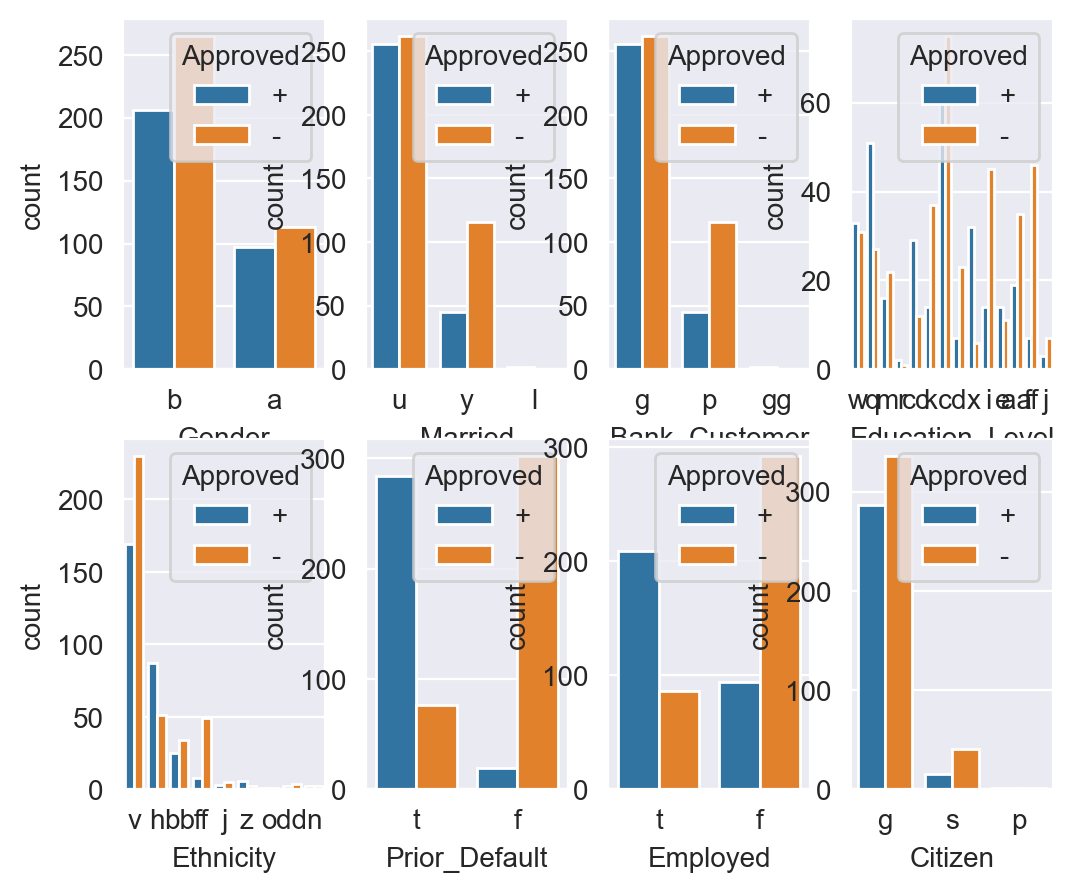

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [416]:
categorical = [var for var in df.columns if df[var].dtype == 'O']
numerical = [var for var in df.columns if df[var].dtype != 'O']

fig, ax = plt.subplots(2, 4)
row = 0
col = 0
plt.rcParams['figure.figsize'] = [20, 10]
for i,predictor in enumerate(df[categorical].drop(columns='Approved')):
    plt.figure(i)
    sns.countplot(data=df[categorical],x=predictor,hue='Approved',ax=ax[row][col])
    col += 1
    col = col % 4
    if col == 0:
        row += 1

While not all categorical values are deterministic of the dependent variable, some, like Education_Level, Prior_Default, and Employed, did show a very clear distinction in determining whether a particular sample is approved or not.

##### Multivariate visualization
##### Quantitative vs. Quantitative
##### Correlation Matrix

<AxesSubplot:>

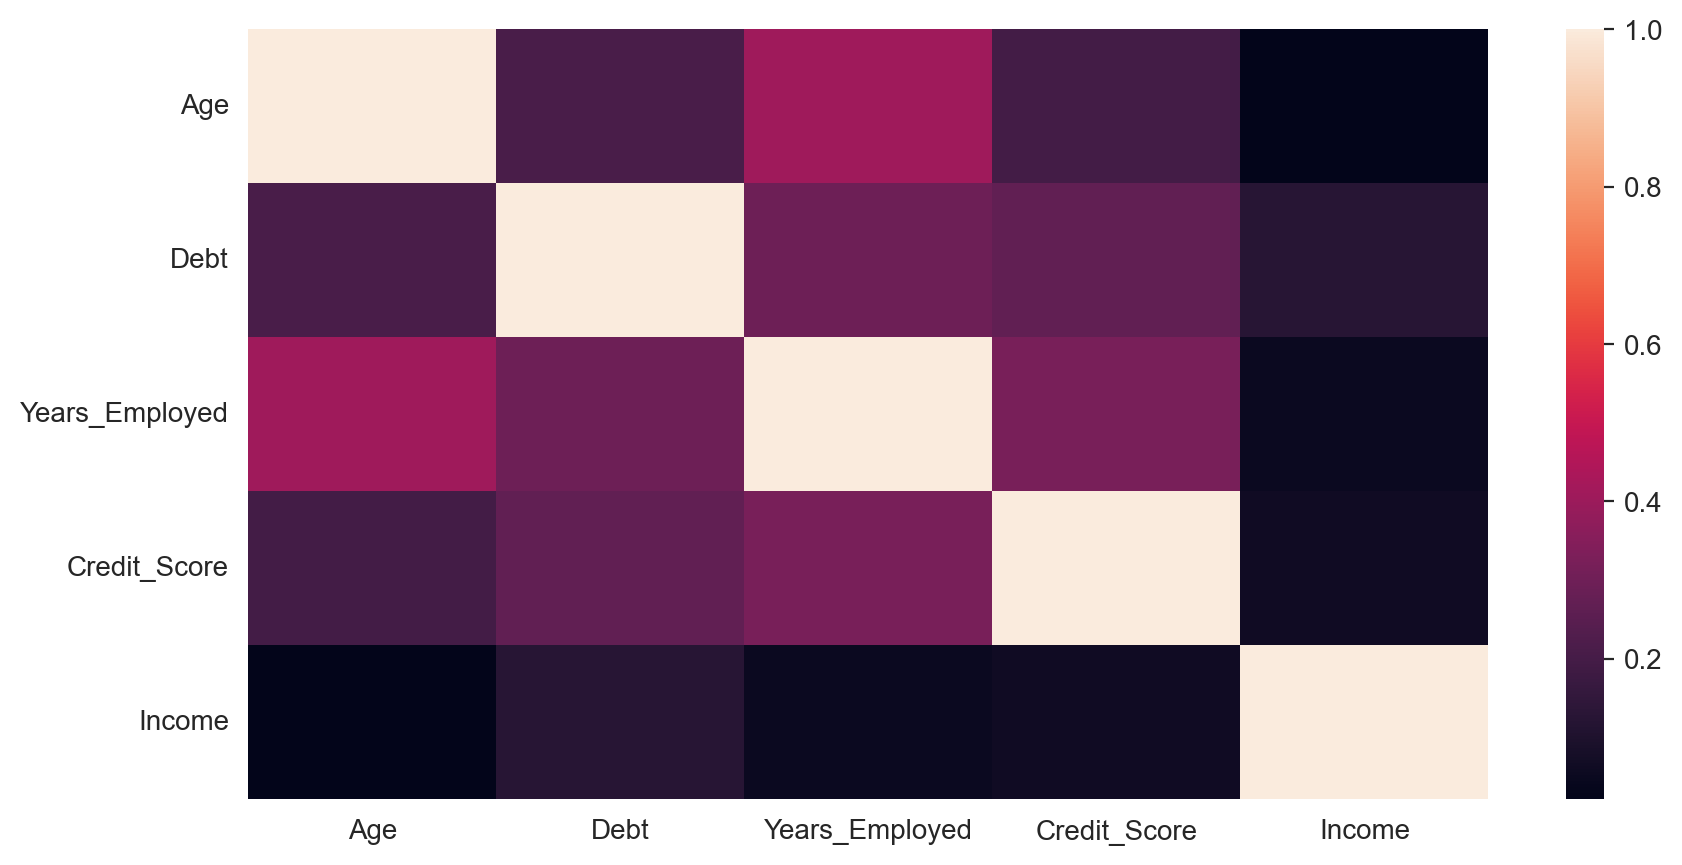

In [417]:
plt.rcParams['figure.figsize'] = [10, 5]
corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix)

While this correlation matrix shows no strong correlation between the numerical variables, it did point out that each did at least play a part in determining the dependent variable.

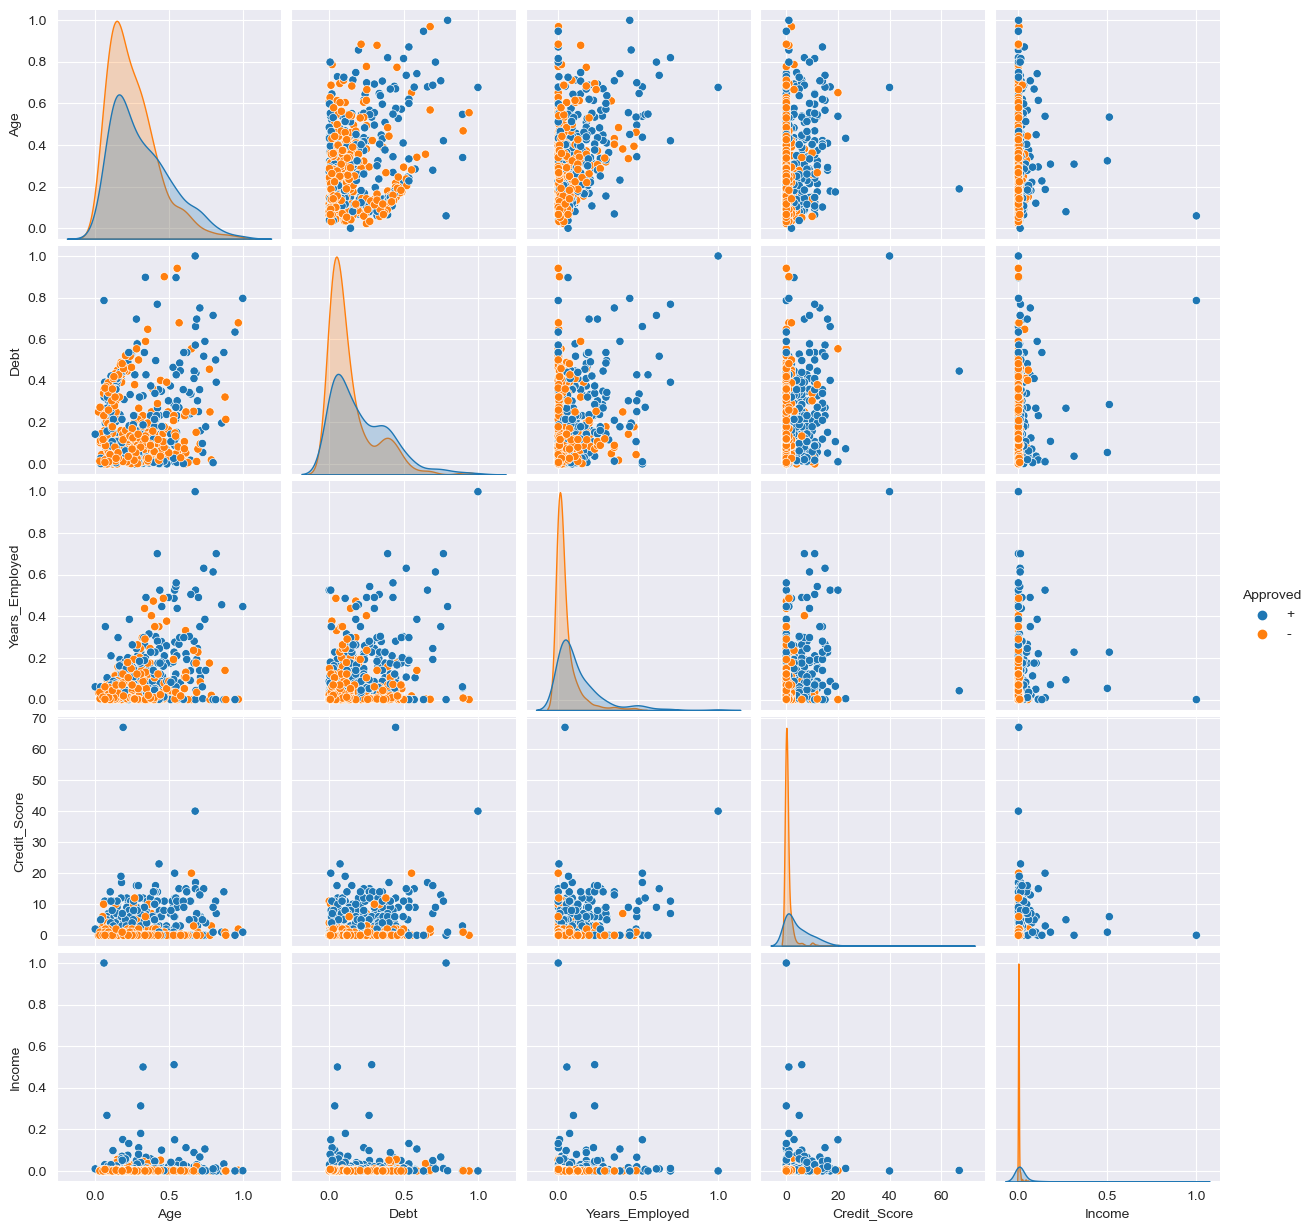

In [418]:
#scatterplot matrix - pairplot
%config InlineBackend.figure_format = 'png'
df_pair = df.copy().drop(columns=categorical[:-1])
sns.pairplot(data=df_pair, hue="Approved");

With this pairplot, it is clear why there were no strong correlations. While the approved class, ‘+’, shows a wide spread of values across the numerical variables, the denied class, ‘-’, have an abundance of 0’s for these categories.

In [419]:
%config InlineBackend.figure_format = 'retina'

#### K Nearest Neighbors

[Text(0.5, 1.0, 'Accuracy with K number of nearest neighbors')]

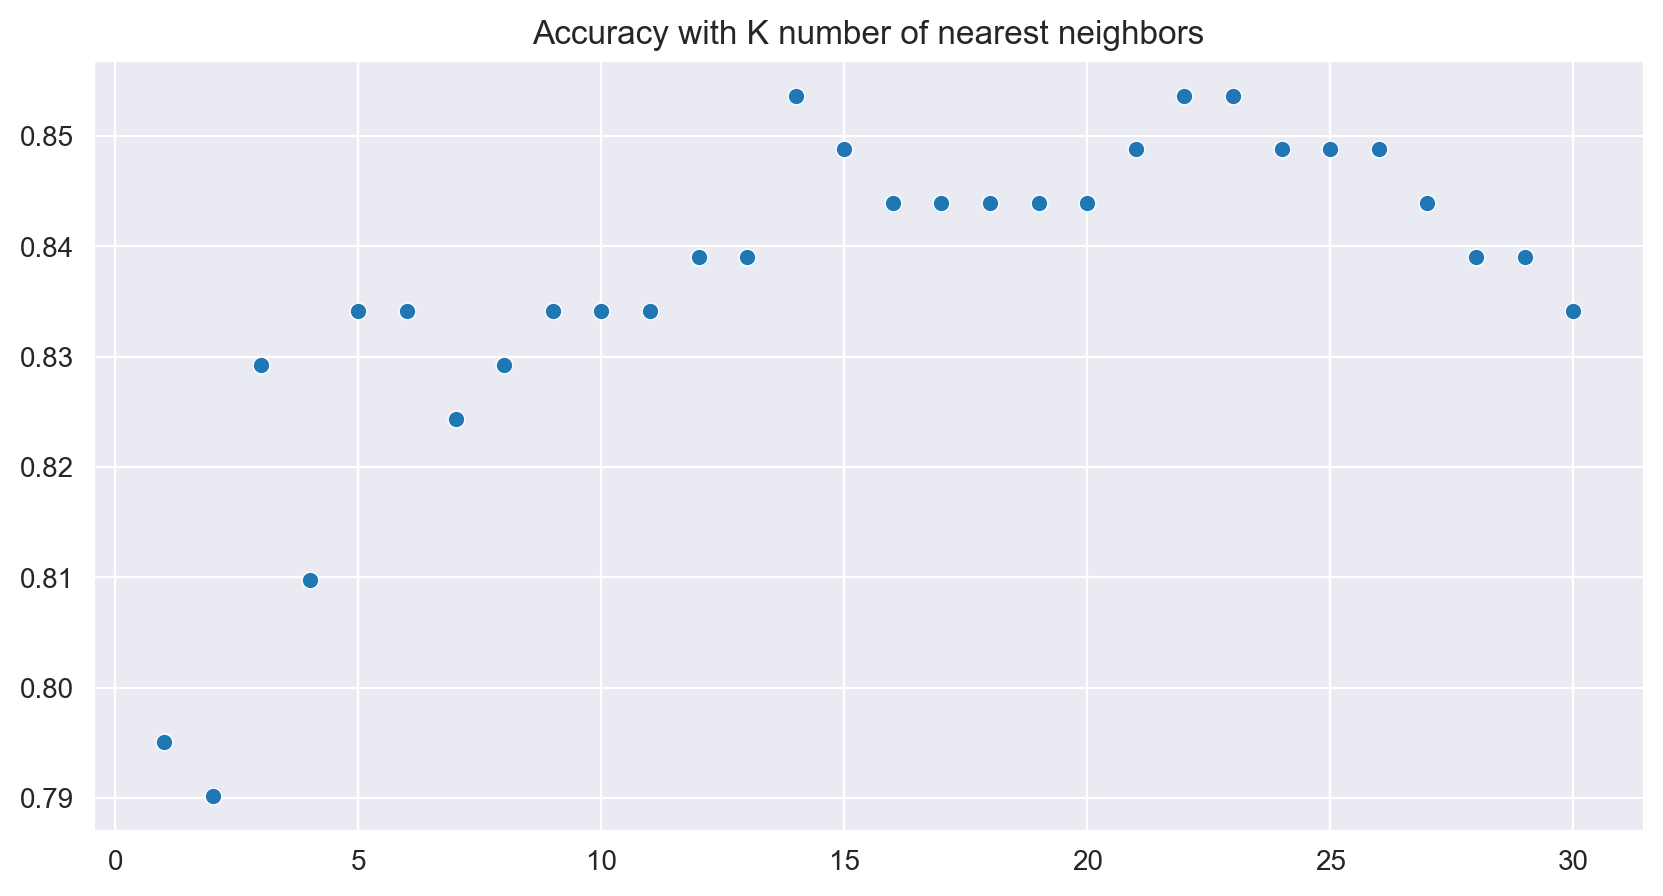

In [420]:
df_KNN = df.copy()

df_KNN['Approved'] = np.where(df_KNN.Approved == '+', 1, 0)

X_KNN = df_KNN.drop(columns=['Approved'])

y_KNN = df_KNN['Approved']

#Create KNN Model to be implemented into pipeline

knn_x_values = []
knn_y_values = []

for i in range(1,31):

    knn = KNeighborsClassifier(n_neighbors=i)

    #create pipeline since some features are categorical
    KNN_transformation = make_column_transformer(
        (OneHotEncoder(), ['Gender','Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 'Prior_Default','Employed','Citizen']),
        remainder='passthrough')

    pipe = make_pipeline(KNN_transformation, knn)

    X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_KNN, y_KNN, test_size=0.3, random_state=0)

    pipe.fit(X_train_KNN,y_train_KNN)

    predicted = pipe.predict(X_test_KNN)

    acc = metrics.accuracy_score(y_test_KNN, predicted)
    knn_x_values.append(i)
    knn_y_values.append(acc)

sns.scatterplot(x=knn_x_values, y=knn_y_values).set(title='Accuracy with K number of nearest neighbors')


In [421]:
knn_y_values[13] # k of 14

0.8536585365853658

[Text(0.5, 1.0, 'Training Confusion Matrix')]

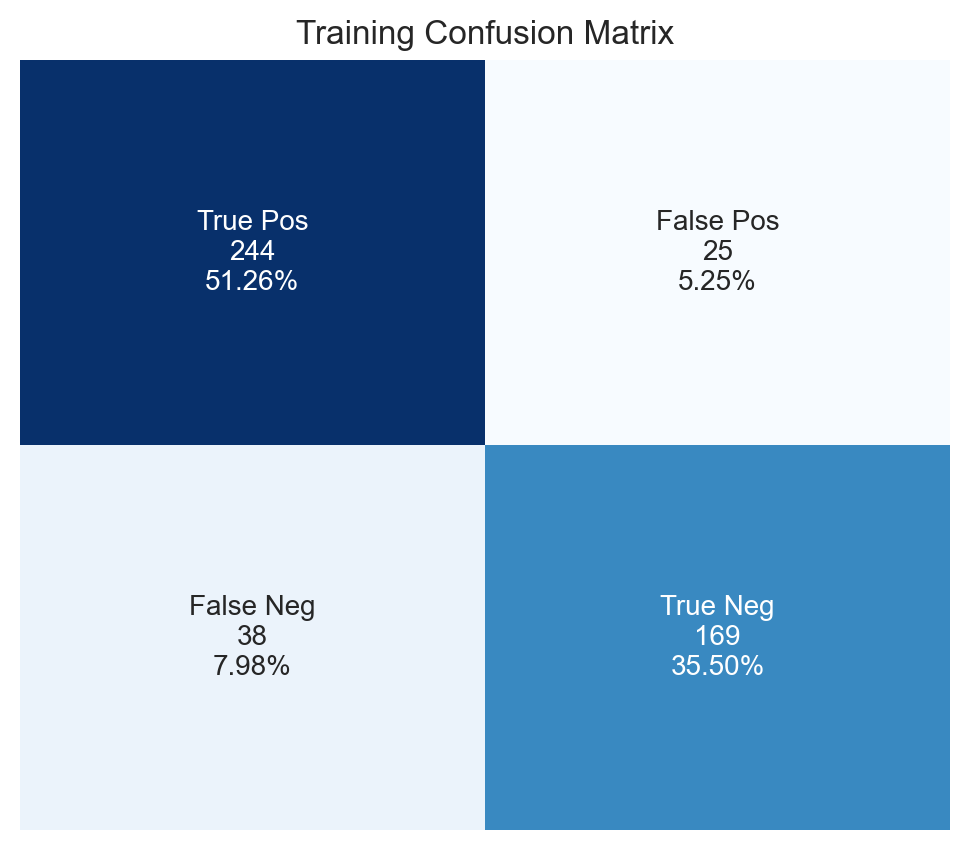

In [422]:
knn = KNeighborsClassifier(n_neighbors=14)

#create pipeline since some features are categorical
KNN_transformation = make_column_transformer(
    (OneHotEncoder(), ['Gender','Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 'Prior_Default','Employed','Citizen']),
    remainder='passthrough')

pipe = make_pipeline(KNN_transformation, knn)

X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_KNN, y_KNN, test_size=0.3, random_state=0)

pipe.fit(X_train_KNN,y_train_KNN)

knn_train_result = pipe.predict(X_train_KNN)
knn_test_result = pipe.predict(X_test_KNN)



#Confusion Matrix Training
knn_train_cm = metrics.confusion_matrix(y_train_KNN, knn_train_result)
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in knn_train_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in knn_train_cm.flatten()/np.sum(knn_train_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.rcParams['figure.figsize'] = [6, 5]

sns.heatmap(knn_train_cm, annot=labels, fmt='', cmap='Blues',yticklabels=False, xticklabels=False, cbar=False).set(title='Training Confusion Matrix')

In [423]:
print(metrics.classification_report(y_train_KNN, knn_train_result))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       269
           1       0.87      0.82      0.84       207

    accuracy                           0.87       476
   macro avg       0.87      0.86      0.86       476
weighted avg       0.87      0.87      0.87       476



In [424]:
print(metrics.classification_report(y_train_KNN, knn_train_result))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       269
           1       0.87      0.82      0.84       207

    accuracy                           0.87       476
   macro avg       0.87      0.86      0.86       476
weighted avg       0.87      0.87      0.87       476



In [425]:
TP = knn_train_cm[0,0]
TN = knn_train_cm[1,1]
FP = knn_train_cm[0,1]
FN = knn_train_cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy:\t{0:0.4f}'.format(classification_accuracy))
# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error:\t\t{0:0.4f}'.format(classification_error))
# print precision score
precision = TP / float(TP + FP)
print('Precision:\t\t\t{0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall or Sensitivity:\t\t{0:0.4f}'.format(recall))
true_positive_rate = TP / float(TP + FN)
print('True Positive Rate:\t\t{0:0.4f}'.format(true_positive_rate))
false_positive_rate = FP / float(FP + TN)
print('False Positive Rate:\t\t{0:0.4f}'.format(false_positive_rate))
specificity = TN / (TN + FP)
print('Specificity:\t\t\t{0:0.4f}'.format(specificity))

Classification accuracy:	0.8676
Classification error:		0.1324
Precision:			0.9071
Recall or Sensitivity:		0.8652
True Positive Rate:		0.8652
False Positive Rate:		0.1289
Specificity:			0.8711


[Text(0.5, 1.0, 'Testing Confusion Matrix')]

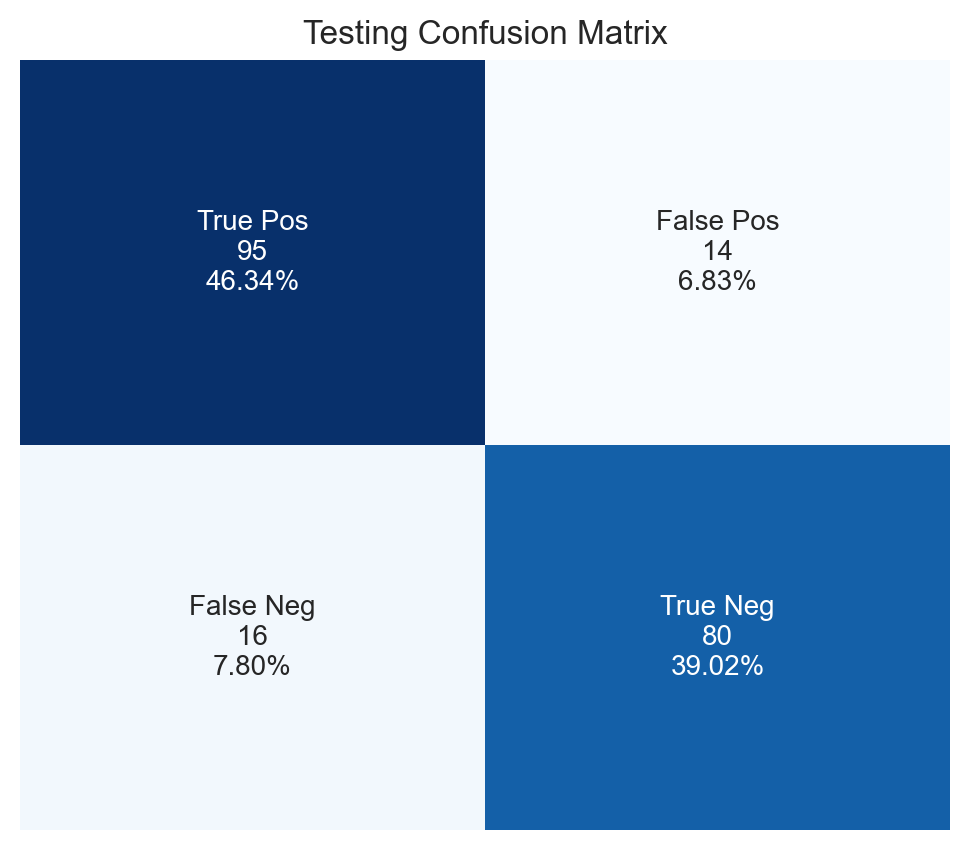

In [426]:
knn_test_cm = metrics.confusion_matrix(y_test_KNN, knn_test_result)
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in knn_test_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in knn_test_cm.flatten()/ np.sum(knn_test_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.rcParams['figure.figsize'] = [6, 5]
sns.heatmap(knn_test_cm, annot=labels, fmt='', cmap='Blues', yticklabels=False,xticklabels=False, cbar=False).set(title='Testing Confusion Matrix')

In [427]:
print(metrics.classification_report(y_test_KNN, knn_test_result))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       109
           1       0.85      0.83      0.84        96

    accuracy                           0.85       205
   macro avg       0.85      0.85      0.85       205
weighted avg       0.85      0.85      0.85       205



In [428]:
TP = knn_test_cm[0,0]
TN = knn_test_cm[1,1]
FP = knn_test_cm[0,1]
FN = knn_test_cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy:\t{0:0.4f}'.format(classification_accuracy))

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error:\t\t{0:0.4f}'.format(classification_error))
# print precision score
precision = TP / float(TP + FP)
print('Precision:\t\t\t{0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall or Sensitivity:\t\t{0:0.4f}'.format(recall))
true_positive_rate = TP / float(TP + FN)
print('True Positive Rate:\t\t{0:0.4f}'.format(true_positive_rate))
false_positive_rate = FP / float(FP + TN)
print('False Positive Rate:\t\t{0:0.4f}'.format(false_positive_rate))
specificity = TN / (TN + FP)
print('Specificity:\t\t\t{0:0.4f}'.format(specificity))

Classification accuracy:	0.8537
Classification error:		0.1463
Precision:			0.8716
Recall or Sensitivity:		0.8559
True Positive Rate:		0.8559
False Positive Rate:		0.1489
Specificity:			0.8511


What we see here is a relatively low accuracy as compared to the other two models in this report. This model could be suffering from the phenomenon known as the “Curse of Dimensionality” meaning there is too many features which cause too much noise in the data. Having categorical features causes the data to make many splits, whereas numerical features causes the data only have a single split. KNN performs well with low dimensionality. Overall, the model still performs well since the data has been cleaned and prepared using imputation. The KNN model is the simplest model in this report, and most likely will be used by recommendation services like “Spotify” or “Netflix”.

### Logistic Regression

In [429]:
df_LogR = df.copy()

df_LogR['Approved'] = np.where(df_KNN.Approved == '+', 1, 0)

X_LogR = df_KNN.drop(columns=['Approved'])

y_LogR = df_KNN['Approved']



LogR = LogisticRegression(max_iter=1000)

#create pipeline since some features are categorical
LogR_transformation = make_column_transformer(
    (OneHotEncoder(), ['Gender','Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 'Prior_Default','Employed','Citizen']),
    remainder='passthrough')

pipe = make_pipeline(LogR_transformation, LogR)

X_train_LogR, X_test_LogR, y_train_LogR, y_test_LogR = train_test_split(X_LogR, y_LogR, test_size=0.3, random_state=0)

pipe.fit(X_train_LogR, y_train_LogR)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Married',
                                                   'Bank_Customer',
                                                   'Education_Level',
                                                   'Ethnicity', 'Prior_Default',
                                                   'Employed', 'Citizen'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Accuracy:	0.907563025210084
Precision:	0.8687782805429864
Recall:		0.927536231884058
F1 score:	0.897196261682243


[Text(0.5, 1.0, 'Training Confusion Matrix')]

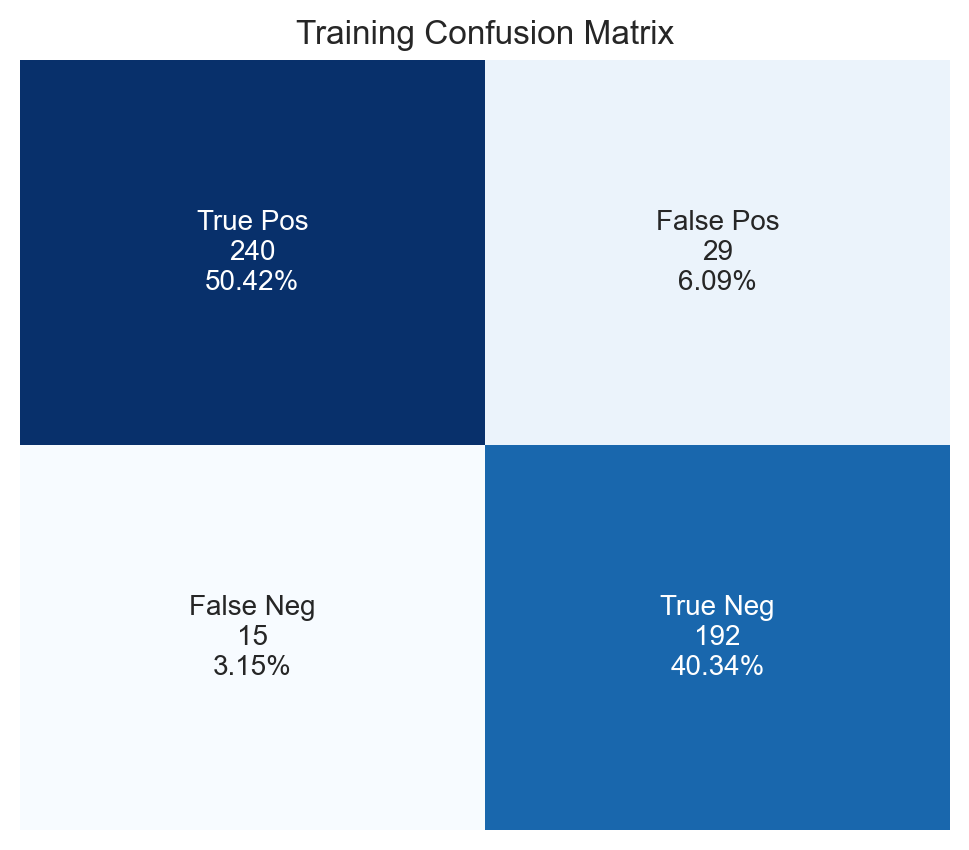

In [430]:
LogR_train_result = pipe.predict(X_train_LogR)

print(f"Accuracy:\t{metrics.accuracy_score(y_train_LogR, LogR_train_result)}")
print(f"Precision:\t{metrics.precision_score(y_train_LogR, LogR_train_result)}")
print(f"Recall:\t\t{metrics.recall_score(y_train_LogR, LogR_train_result)}")
print(f"F1 score:\t{metrics.f1_score(y_train_LogR, LogR_train_result)}")
lreg_train_cm = metrics.confusion_matrix(y_train_LogR, LogR_train_result)
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in lreg_train_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lreg_train_cm.flatten()/np.sum(lreg_train_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.rcParams['figure.figsize'] = [6, 5]
sns.heatmap(lreg_train_cm, annot=labels, fmt='', cmap='Blues', yticklabels=False, xticklabels=False, cbar=False).set(title='Training Confusion Matrix')

Accuracy: 0.8390243902439024
Precision: 0.8118811881188119
Recall: 0.8541666666666666
F1 score: 0.83248730964467


[Text(0.5, 1.0, 'Testing Confusion Matrix')]

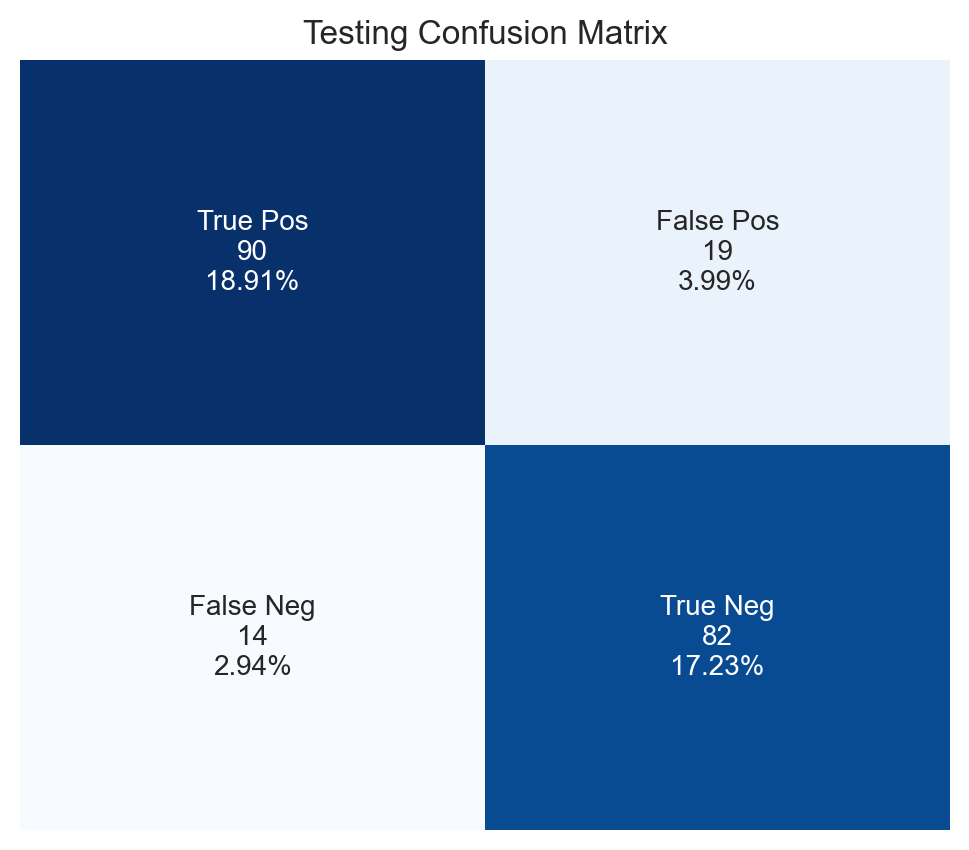

In [431]:
LogR_test_result = pipe.predict(X_test_LogR)
print(f"Accuracy: {pipe.score(X_test_LogR, y_test_LogR)}")
print(f"Precision: {metrics.precision_score(y_test_LogR, LogR_test_result)}")
print(f"Recall: {metrics.recall_score(y_test_LogR, LogR_test_result)}")
print(f"F1 score: {metrics.f1_score(y_test_LogR, LogR_test_result)}")
lreg_test_cm = metrics.confusion_matrix(y_test_LogR, LogR_test_result)
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in lreg_test_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lreg_test_cm.flatten()/np.sum(lreg_train_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.rcParams['figure.figsize'] = [6, 5]
sns.heatmap(lreg_test_cm, annot=labels, fmt='', cmap='Blues',yticklabels=False, xticklabels=False, cbar=False).set(title='Testing Confusion Matrix')

#### Support Vector Machine

In [432]:
df_SVM = df.copy()

df_SVM['Approved'] = np.where(df_SVM.Approved == '+', 1, 0)

X_SVM = df_KNN.drop(columns=['Approved'])

y_SVM = df_SVM['Approved']



svm = Svm.SVC(kernel='linear',C=100)

#create pipeline since some features are categorical
SVM_transformation = make_column_transformer(
    (OneHotEncoder(), ['Gender','Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 'Prior_Default','Employed','Citizen']),
    remainder='passthrough')

pipe = make_pipeline(SVM_transformation, svm)

X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X_SVM, y_SVM, test_size=0.3, random_state=0)

pipe.fit(X_train_SVM, y_train_SVM)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Married',
                                                   'Bank_Customer',
                                                   'Education_Level',
                                                   'Ethnicity', 'Prior_Default',
                                                   'Employed', 'Citizen'])])),
                ('svc', SVC(C=100, kernel='linear'))])

Accuracy:	 0.8865546218487395
Precision:	 0.9130434782608695
Recall:		 0.84
F1 score:	 0.8749999999999999


[Text(0.5, 1.0, 'Training Confusion Matrix')]

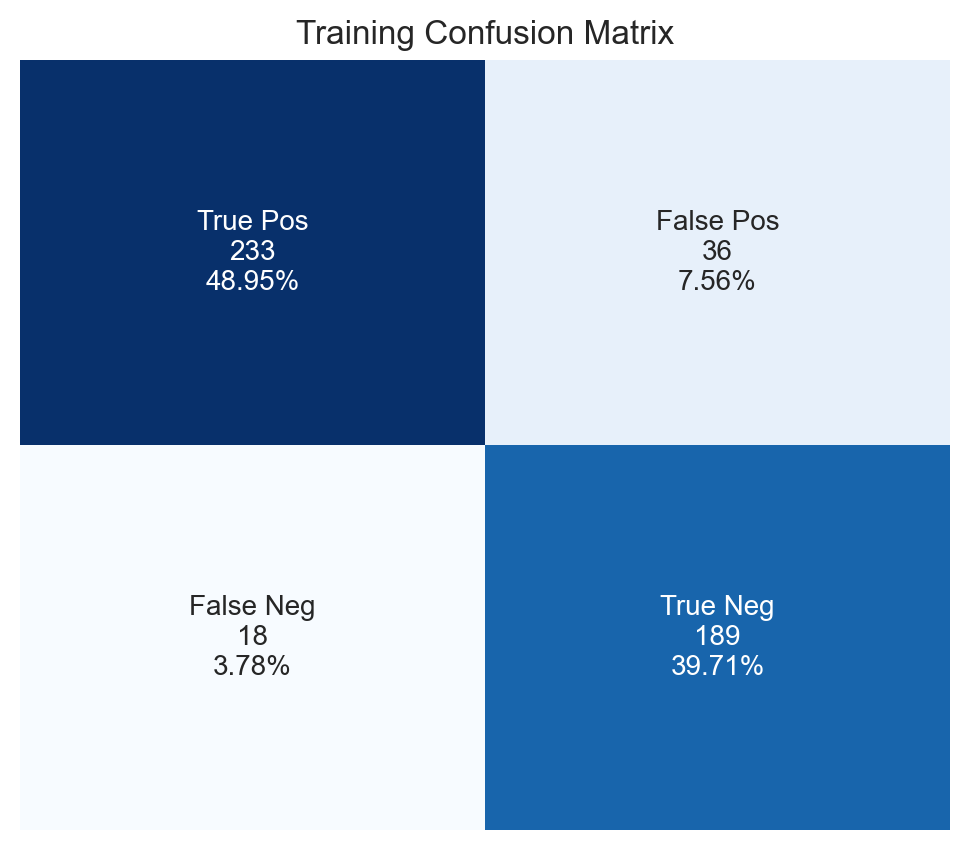

In [433]:
SVM_train_result = pipe.predict(X_train_SVM)

print("Accuracy:\t",metrics.accuracy_score(SVM_train_result, y_train_SVM))
print("Precision:\t",metrics.precision_score(SVM_train_result, y_train_SVM))
print("Recall:\t\t",metrics.recall_score(SVM_train_result, y_train_SVM))
print("F1 score:\t",metrics.f1_score(SVM_train_result, y_train_SVM))

svm_train_cm = metrics.confusion_matrix(y_train_SVM, SVM_train_result)

group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in svm_train_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in svm_train_cm.flatten()/np.sum(svm_train_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.rcParams['figure.figsize'] = [6, 5]
sns.heatmap(svm_train_cm, annot=labels, fmt='', cmap='Blues', yticklabels=False, xticklabels=False, cbar=False).set(title='Training Confusion Matrix')

Accuracy:	 0.8390243902439024
Precision:	 0.8058252427184466
Recall:		 0.8645833333333334
F1 score:	 0.8341708542713568


[Text(0.5, 1.0, 'Testing Confusion Matrix')]

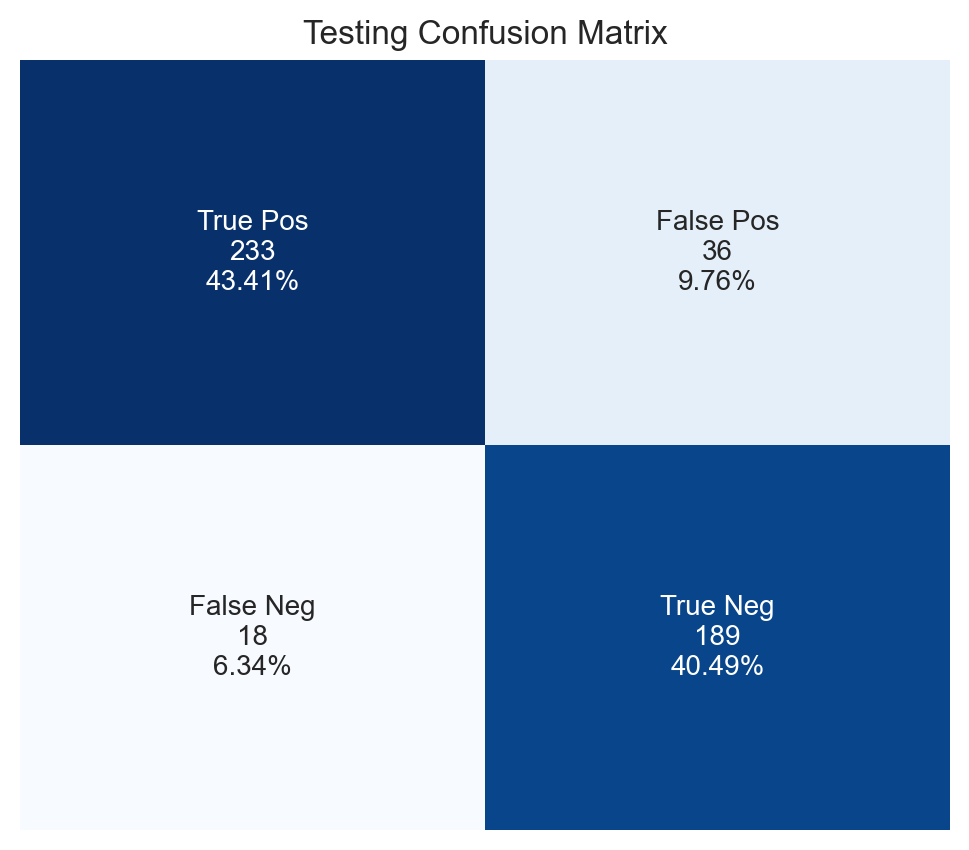

In [434]:
SVM_test_result = pipe.predict(X_test_SVM)

print("Accuracy:\t",metrics.accuracy_score(y_test_SVM, SVM_test_result))
print("Precision:\t",metrics.precision_score(y_test_SVM, SVM_test_result))
print("Recall:\t\t",metrics.recall_score(y_test_SVM, SVM_test_result))
print("F1 score:\t",metrics.f1_score(y_test_SVM, SVM_test_result))
svm_test_cm = metrics.confusion_matrix(y_test_SVM, SVM_test_result)
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in svm_train_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in svm_test_cm.flatten()/np.sum(svm_test_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.rcParams['figure.figsize'] = [6, 5]
sns.heatmap(svm_test_cm, annot=labels, fmt='', cmap='Blues', yticklabels=False,xticklabels=False, cbar=False).set(title='Testing Confusion Matrix')

#### Comparison

##### KNN

		Train			Test
Accuracy:	0.8676470588235294	0.8536585365853658
Precision:	0.8711340206185567	0.851063829787234
Recall:		0.8164251207729468	0.8333333333333334
F1 score:	0.8428927680798005	0.8421052631578947


[Text(0.5, 1.0, 'Testing Confusion Matrix')]

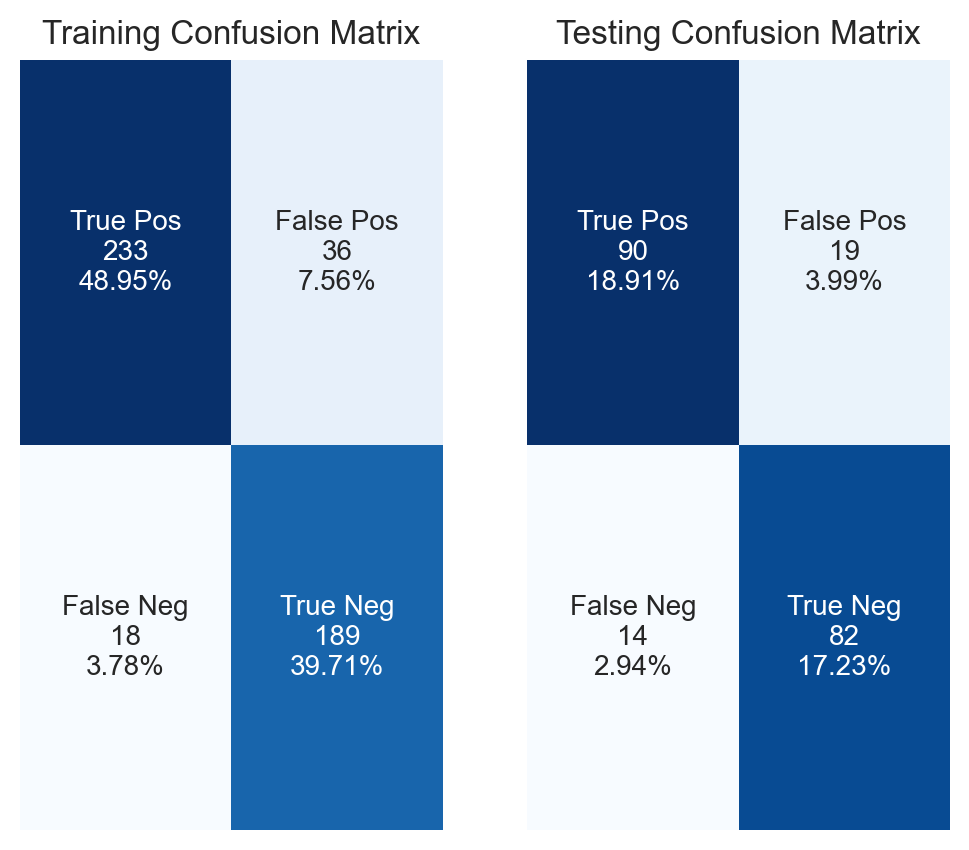

In [435]:

print("\t\tTrain\t\t\tTest")
print(f"Accuracy:\t{metrics.accuracy_score(y_train_KNN, knn_train_result)}\t{metrics.accuracy_score(y_test_KNN, knn_test_result)}")
print(f"Precision:\t{metrics.precision_score(y_train_KNN, knn_train_result)}\t{metrics.precision_score(y_test_KNN, knn_test_result)}")
print(f"Recall:\t\t{metrics.recall_score(y_train_KNN, knn_train_result)}\t{metrics.recall_score(y_test_KNN, knn_test_result)}")
print(f"F1 score:\t{metrics.f1_score(y_train_KNN, knn_train_result)}\t{metrics.f1_score(y_test_KNN, knn_test_result)}")
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in svm_train_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in svm_train_cm.flatten()/np.sum(svm_train_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(1, 2)

sns.heatmap(svm_train_cm, annot=labels, fmt='', cmap='Blues',yticklabels=False, xticklabels=False, cbar=False, ax=ax[0]).set(title='Training Confusion Matrix')
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in lreg_test_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lreg_test_cm.flatten()/np.sum(lreg_train_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lreg_test_cm, annot=labels, fmt='', cmap='Blues',yticklabels=False, xticklabels=False, cbar=False, ax=ax[1]).set(title='Testing Confusion Matrix')

As previously stated, since KNN is a simpler, for lack of a better word, it can only perform so well with the given conditions of the input. However it does serve as a very good baseline for comparison on how the other models have performed; nearing 80% on all relevant metrics.

##### Logistic Regression

		Train			Test
Accuracy:	0.907563025210084	0.8390243902439024
Precision:	0.8687782805429864	0.8118811881188119
Recall:		0.927536231884058	0.8541666666666666
F1 score:	0.897196261682243	0.83248730964467


[Text(0.5, 1.0, 'Testing Confusion Matrix')]

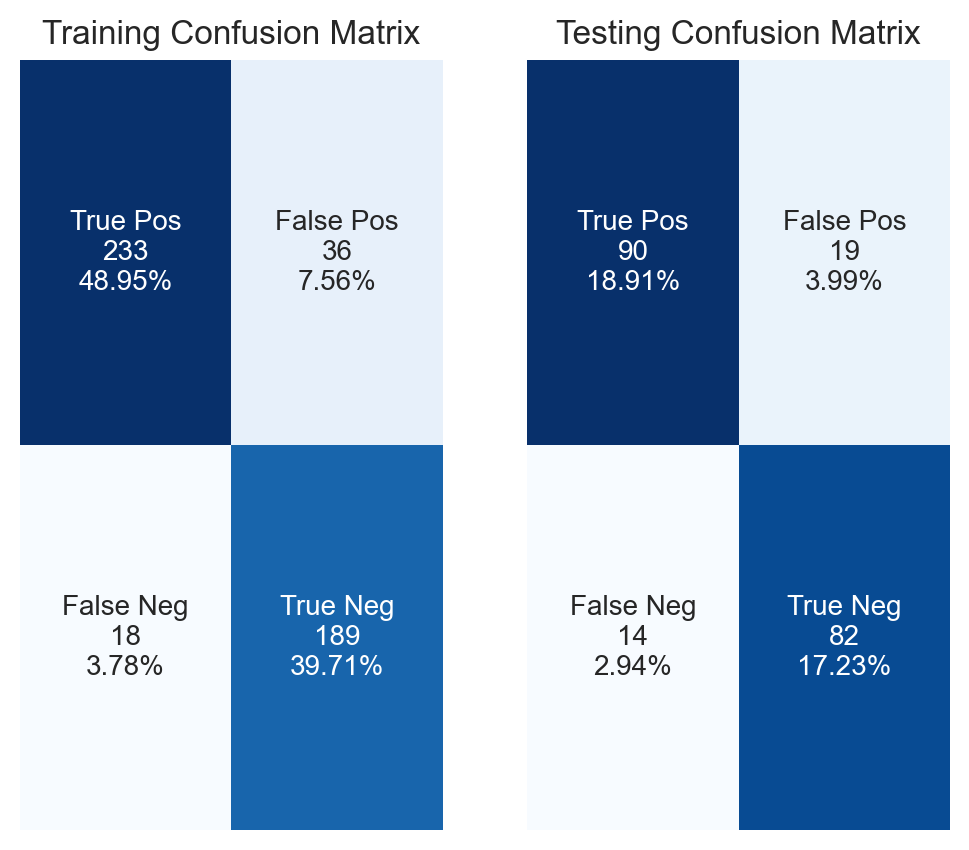

In [436]:
print("\t\tTrain\t\t\tTest")
print(f"Accuracy:\t{metrics.accuracy_score(y_train_LogR, LogR_train_result)}\t{metrics.accuracy_score(y_test_LogR, LogR_test_result)}")
print(f"Precision:\t{metrics.precision_score(y_train_LogR, LogR_train_result)}\t{metrics.precision_score(y_test_LogR, LogR_test_result)}")
print(f"Recall:\t\t{metrics.recall_score(y_train_LogR, LogR_train_result)}\t{metrics.recall_score(y_test_LogR, LogR_test_result)}")
print(f"F1 score:\t{metrics.f1_score(y_train_LogR, LogR_train_result)}\t{metrics.f1_score(y_test_LogR, LogR_test_result)}")
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in svm_train_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in svm_train_cm.flatten()/np.sum(svm_train_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(1, 2)

sns.heatmap(svm_train_cm, annot=labels, fmt='', cmap='Blues',yticklabels=False, xticklabels=False, cbar=False, ax=ax[0]).set(title='Training Confusion Matrix')
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in lreg_test_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lreg_test_cm.flatten()/np.sum(lreg_train_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lreg_test_cm, annot=labels, fmt='', cmap='Blues', yticklabels=False, xticklabels=False, cbar=False, ax=ax[1]).set(title='Testing Confusion Matrix')

While logistic regression seems to have performed the best by a margin, it must be said that it is only so because of the current split used. Given a different split, or possibly a complete input without imputation, SVM may overtake logistic regression in performance. However, the performance of the model despite these conditions makes it a good recommendation for the type of situation the dataset entails; credit approval.

##### SVM

		Train			Test
Accuracy:	0.8865546218487395	0.8390243902439024
Precision:	0.84	0.8058252427184466
Recall:		0.9130434782608695	0.8645833333333334
F1 score:	0.8749999999999999	0.8341708542713568


[Text(0.5, 1.0, 'Testing Confusion Matrix')]

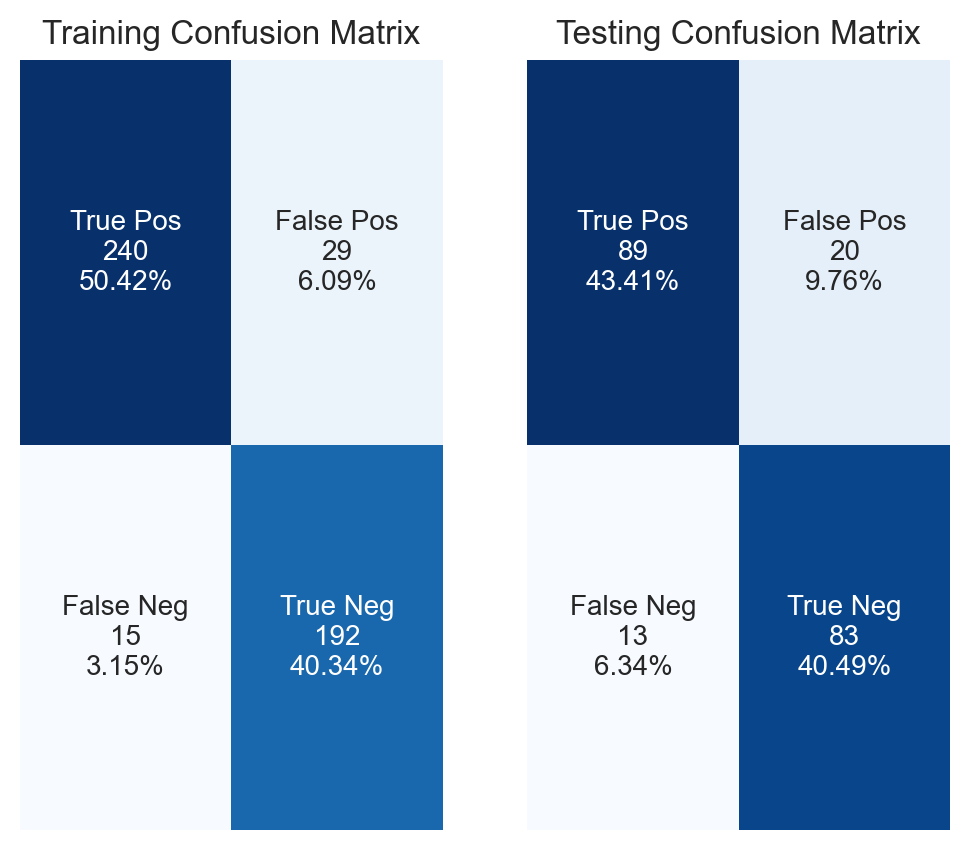

In [437]:
print("\t\tTrain\t\t\tTest")
print(f"Accuracy:\t{metrics.accuracy_score(y_train_SVM, SVM_train_result)}\t{metrics.accuracy_score(y_test_SVM, SVM_test_result)}")
print(f"Precision:\t{metrics.precision_score(y_train_SVM, SVM_train_result)}\t{metrics.precision_score(y_test_SVM, SVM_test_result)}")
print(f"Recall:\t\t{metrics.recall_score(y_train_SVM, SVM_train_result)}\t{metrics.recall_score(y_test_SVM, SVM_test_result)}")
print(f"F1 score:\t{metrics.f1_score(y_train_SVM, SVM_train_result)}\t{metrics.f1_score(y_test_SVM, SVM_test_result)}")
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in lreg_train_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lreg_train_cm.flatten()/np.sum(lreg_train_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(1, 2)
sns.heatmap(lreg_train_cm, annot=labels, fmt='', cmap='Blues', yticklabels=False, xticklabels=False, cbar=False, ax=ax[0]).set(title='Training Confusion Matrix')
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in svm_test_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in svm_test_cm.flatten()/np.sum(svm_test_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(svm_test_cm, annot=labels, fmt='', cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax=ax[1]).set(title='Testing Confusion Matrix')

While being the most sophisticated algorithm for classification used here, it also was the slowest. It did perform as well as logistic regression, giving similar or sometimes better metrics than logistic regression. However, it did also take almost exponentially longer amount of time to achieve the same results. Thus, while the SVM model is consistent and powered through the conditions of the input, it did so in a much slower pace. Thus, the recommendation stands with logistic regression.